## In this notebook we will try to fit image with PSF. 

### 1. Create standard PSF: 
    (1) Download PSF fits file  
    (2) The PSF max do not need to be at the center.  The photutils will find the peak in the fitting. 
    (3) The dimension of the PSF needs to be odd number. (e.g. 51 by 51)
    
### 2. Measure photometry with PSF 
    (1) Use photutils packages. 
    (2) Creat a dictionary to store PSF and flux correction, unit convertion 
    (3) Compare the measurement with catalogs 
    

In [837]:
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
import pandas as pd 
import astropy.io.fits as fits
from astropy.table import Table

from astropy.stats import sigma_clipped_stats


from astropy.modeling.fitting import LevMarLSQFitter
from photutils.psf import PSFPhotometry, DAOGroup, FittableImageModel , BasicPSFPhotometry

from photutils.detection import IRAFStarFinder

## Herschel PSF   

download PSF from :   
PACS PSF (100, 160 micron) https://irsa.ipac.caltech.edu/data/Herschel/PEP/overview.html  
SPIRE Beam map (250, 350, 500 micron)https://irsa.ipac.caltech.edu/data/Herschel/HerMES/overview.html  
 
The PSF file may be oversample (smaller pixel scale than the survey).  We need to rebin the PSF to match the data.  Both PACS and SPIRE PSF do not need normalization.                     

PACS PSF photometry flux correction can be found in Table 4 (and equation 1) : https://irsa.ipac.caltech.edu/data/Herschel/PEP/docs/readme_PEP_global.pdf 

In [632]:
# Part one create PSF   (24, 70, 100, 160, 250, 350, 500)

# We can use 250 micron as practice   
# 1. Read the PSF file 

band = '250'

psf_img, psf_hdr = fits.getdata(f'../../cosmos/herschel/psf/beam_image_{band}_SMAP_v6.0.fits', header = True)

psf_img = np.nan_to_num(psf_img, nan=0.0)
psf_pixelscale = abs(psf_hdr['CD1_1'])*60*60

# Rebin so that the pixel scale is the same 
zoom_factor = np.round( psf_pixelscale/phot_df['pixscale'][f'{band}'], 2 ) 
psf_rebinned = zoom(psf_img, zoom_factor, order=3) 

# cut so that the PSF is at the center  
xdim,  ydim = np.shape(psf_rebinned)
xc = xdim//2
yc = ydim//2

hx = 51//2 
hy = 51//2 

psf_data = psf_rebinned[xc-hx: xc+hx+1, yc-hy:yc+hy+1]

# don't normalize for SPHIRE (since the unit is Jy/beam   1 beam = 1 psf )
#psf_data = psf_data/np.nansum(psf_data)
print(np.shape(psf_data))

np.save( f'../../cosmos/herschel/psf/psf_{band}.npy', psf_data)






(51, 51)


In [642]:
# Part one create PSF   (24, 70, 100, 160, 250, 350, 500)

# We can use 250 micron as practice   
# 1. Read the PSF file 

band = '100'


psf_img, psf_hdr = fits.getdata(f'../../cosmos/herschel/psf/pep_COSMOS_green_Psf.DR1.fits', header = True)
psf_img = np.nan_to_num(psf_img, nan=0.0)
#psf_pixelscale = abs(psf_hdr['CD1_1'])*60*60

# Rebin so that the pixel scale is the same 
zoom_factor = 1. #np.round( psf_pixelscale/phot_df['pixscale'][f'{band}'], 2 ) 
psf_rebinned = zoom(psf_img, zoom_factor, order=3) 

# cut so that the PSF is at the center  
xdim,  ydim = np.shape(psf_rebinned)
xc = xdim//2
yc = ydim//2

hx = 51//2 
hy = 51//2 

psf_data = psf_rebinned[xc-hx: xc+hx+1, yc-hy:yc+hy+1]

# don't normalize for SPHIRE (since the unit is Jy/beam   1 beam = 1 psf )
#psf_data = psf_data/np.nansum(psf_data)
print(np.shape(psf_data))

np.save( f'../../cosmos/herschel/psf/psf_{band}.npy', psf_data)






(51, 51)


## Spitzer MIPS 24, 70 ,160 micron.  

### Don't use the mips 160 micron. The flux calibration is messed up. 
##  

Download PSF file from : https://irsa.ipac.caltech.edu/data/SPITZER/docs/mips/calibrationfiles/prfs/?utm_source=chatgpt.com 

The unit of Spitzer MISP is in Mjr/sr.   
The PSF needs to be normalized. Pixel scale is in the file name. 

In [742]:
# Part one create PSF   (24, 70, 100, 160, 250, 350, 500)

# We can use 250 micron as practice   
# 1. Read the PSF file 

band = 'mips24'


psf_img, psf_hdr = fits.getdata(f'../../cosmos/herschel/psf/mips24_prf_mosaic_2.45_4x.fits', header = True)
psf_img = np.nan_to_num(psf_img, nan=0.0)
psf_pixelscale = abs(psf_hdr['CDELT2'])*60*60

# Rebin so that the pixel scale is the same 
zoom_factor = np.round( psf_pixelscale/phot_df['pixscale'][f'{band}'], 2 ) 
psf_rebinned = zoom(psf_img, zoom_factor, order=3) 

#No need to trim for MIPS PSF 

psf_data = psf_rebinned

# MIPS need psf normalize 
psf_data = psf_data/np.nansum(psf_data)
print(np.shape(psf_data))

np.save( f'../../cosmos/herschel/psf/psf_{band}.npy', psf_data)






(65, 65)


In [758]:
# Part one create PSF   (24, 70, 100, 160, 250, 350, 500)

# We can use 250 micron as practice   
# 1. Read the PSF file 

band = 'mips70'


psf_img, psf_hdr = fits.getdata(f'../../cosmos/herschel/psf/mips70_prf_mosaic_4.0_4x.fits', header = True)
psf_img = np.nan_to_num(psf_img, nan=0.0)
psf_pixelscale = 4.0/4  # 4.0 arcsecond with resampling of 4 

# Rebin so that the pixel scale is the same 
zoom_factor = np.round( psf_pixelscale/phot_df['pixscale'][f'{band}'], 2 ) 
psf_rebinned = zoom(psf_img, zoom_factor, order=3) 

#No need to trim for MIPS PSF , we pad the side so it's odd number dimension (for the psf photometry package)

psf_data = psf_rebinned
psf_data = np.pad(psf_data, pad_width=((1, 2), (1, 2)), mode='constant', constant_values=0)

# MIPS need psf normalize   ()
psf_data = psf_data/np.nansum(psf_data)
print(np.shape(psf_data))

np.save( f'../../cosmos/herschel/psf/psf_{band}.npy', psf_data)






(25, 25)


In [759]:
# Part one create PSF   (24, 70, 100, 160, 250, 350, 500)

# We can use 250 micron as practice   
# 1. Read the PSF file 

band = 'mips160'


psf_img, psf_hdr = fits.getdata(f'../../cosmos/herschel/psf/mips160_prf_mosaic_8.0_4x.fits', header = True)
psf_img = np.nan_to_num(psf_img, nan=0.0)
psf_pixelscale = 8.0/4  # 4.0 arcsecond with resampling of 4 

# Rebin so that the pixel scale is the same 
zoom_factor = np.round( psf_pixelscale/phot_df['pixscale'][f'{band}'], 2 ) 
psf_rebinned = zoom(psf_img, zoom_factor, order=3) 

#No need to trim for MIPS PSF 

psf_data = psf_rebinned
psf_data = np.pad(psf_data, pad_width=((1, 2), (1, 2)), mode='constant', constant_values=0)


# MIPS need psf normalize   ()
psf_data = psf_data/np.nansum(psf_data)
print(np.shape(psf_data))

np.save( f'../../cosmos/herschel/psf/psf_{band}.npy', psf_data)







(25, 25)


# Example code of PSF photometry fitting 

6.2188196
 id group_id local_bkg ...        qfit                 cfit         flags
--- -------- --------- ... ------------------ --------------------- -----
  1        1       0.0 ... 3.0234933310239507 -0.009120698454191837     0
[336.9505467]


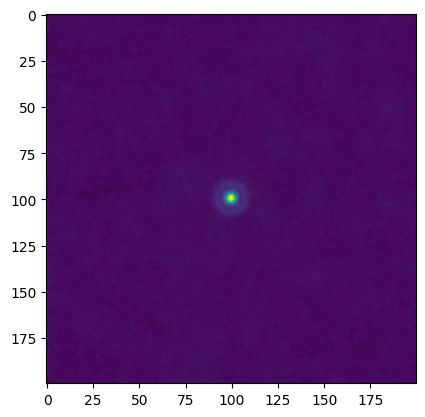

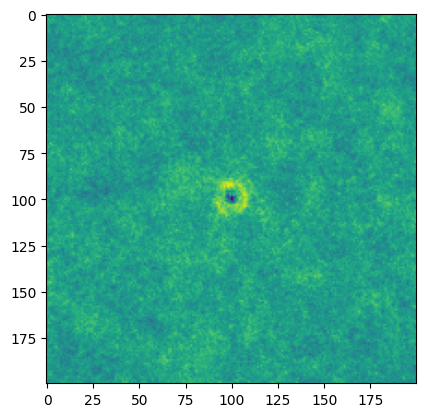

In [681]:
# Wrap PSF in a photutils model

#psf_data = psf_data/np.nansum(psf_data)
print(np.sum(psf_data) )
psf_model = FittableImageModel(psf_data)
psf_model.flux.bounds = (0, None) 

# clean the background
mean, median, std = sigma_clipped_stats(image_data, sigma=3.0, maxiters=5)
bkg_value  = median
image_data = image_data - bkg_value 



# Create initial guess table
init_guess = Table()
init_guess['x_0'] = [image_data.shape[0]/2]
init_guess['y_0'] = [image_data.shape[1]/2]
#init_guess['aperture_radius'] = phot_df['aperture'][band]

# Setup PSF photometry
photometry = PSFPhotometry(
    psf_model=psf_model,  
    fitter=LevMarLSQFitter(),
    fit_shape=np.shape(psf_data),  
    aperture_radius=phot_df['aperture'][band]
)

# Run fitting
result_tab = photometry(data=image_data, init_params=init_guess)

# create residual image 
residual_image = photometry.make_residual_image(data=image_data, psf_shape = np.shape(psf_data)) 
print(result_tab)
print(result_tab['flux_fit'].value/result_tab['flux_err'].value)

plt.imshow( image_data ) 
plt.show()
plt.imshow( residual_image ) 
plt.show()


# Create a Dataframe to record the PSF and correction 

# Rewrite the PSF fitting into a function. 

In [805]:
psf24 = np.load( f'../../cosmos/herschel/psf/psf_mips24.npy')
psf70 = np.load( f'../../cosmos/herschel/psf/psf_mips70.npy')
psfmips160 = np.load( f'../../cosmos/herschel/psf/psf_mips160.npy')
psf100 = np.load( f'../../cosmos/herschel/psf/psf_100.npy')
psf160 = np.load( f'../../cosmos/herschel/psf/psf_160.npy')
psf250 = np.load( f'../../cosmos/herschel/psf/psf_250.npy')
psf350 = np.load( f'../../cosmos/herschel/psf/psf_350.npy')
psf500 = np.load( f'../../cosmos/herschel/psf/psf_500.npy')

phot_df = pd.DataFrame({'key' : ['fuv', 'nuv', 'irac1', 'irac2', 'irac3', 'irac4', 'mips24', 'mips70', 'mips160','100','160','250', '350', '500'],
                  'aperture' : [3.8, 3.8, 2.9, 2.9, 2.9, 2.9, 7, 16, 24, 7.2, 12 , 22, 30, 42    ], 
                  'pixscale': [1.5, 1.5, 0.6, 0.6, 0.6, 0.6,1.2,  4, 8, 1.2, 2.4, 6, 25/3, 12 ], 
                  'psf_data' : [None,None,None,None,None,None, psf24, psf70, psfmips160, psf100,psf160,psf250, psf350, psf500],     
                  'psf_fcorrection' : [1,1,1,1,1,1,(1e6/(60*60*180/np.pi / 1.2 )**2),(1e6/(60*60*180/np.pi / 4 )**2),(1e6/(60*60*180/np.pi / 8 )**2),1/0.667*1.12,1/0.677*1.11, 1,1,1   ],  
                  'psf_ferrcorrection' : [1,1,1,1,1,1,(1e6/(60*60*180/np.pi / 1.2 )**2),(1e6/(60*60*180/np.pi / 4 )**2),(1e6/(60*60*180/np.pi / 8 )**2),1/0.667*1.12*1.35,1/0.677*1.11*1.57, 1,1,1   ] , 
                  'sky1': np.ones(14)*12, 
                  'sky2': np.ones(14)*25, 
                  'apcorrection': [1.2, 1.2, 1.215, 1.233, 1.366, 1.568, 1.61, 2.04, 2.593,1.12/0.667,1.11/0.677,1.275,1.1933,1.2599 ], 
                  '3sigma_depth_mJy':[ 0.145,0.145,0.9e-3*0.6,1.67e-3*0.6,11.3e-3*0.6,14.6e-3*0.6,71e-3*0.6,7.5,70,5,10.2,8.1,10.7,15.4 ],  #All in mJy,   spitzer, mips 3 sigma  ,HERMES 3 sigma mJy
                  '1sigma_depth_Jy':[ 4.83333333e-05, 4.83333333e-05, 1.80000000e-07, 3.34000000e-07,
                                       2.26000000e-06, 2.92000000e-06, 1.42000000e-05, 2.50000000e-03,
                                       2.33333333e-02, 1.66666667e-03, 3.40000000e-03, 2.70000000e-03,
                                       3.56666667e-03, 5.13333333e-03],
                  }).set_index('key')

In [762]:
def impho(data, dataerr = None, key = '250'):


    aperture = phot_df.loc[key, 'aperture'] 
    pixscale = phot_df.loc[key, 'pixscale'] 
    r_pixel = ( aperture/pixscale)
    npix = (r_pixel)**2*np.pi




    position = [ ( np.shape(data)[0]/2,np.shape(data)[1]/2 ) ]
    aperture = CircularAperture(position, r=r_pixel)
    stats1 = ApertureStats(data, aperture, error = dataerr ) 


    annulus_aperture = CircularAnnulus(position, r_in=r_pixel+5, r_out=100)
    stats2 = ApertureStats(data, annulus_aperture)
    skybkg = stats2.median



    signal = stats1.sum 
    noise =  ( stats2.std * np.sqrt(npix)  )  
    flux = np.max([0, signal[0]])

    flux_err = np.sqrt(noise**2 + np.nan_to_num(stats1.sum_err)**2 )[0]


    flux = to_Jy(flux, key)
    flux_err = to_Jy(flux_err, key)
    depth = phot_df.loc[key, '1sigma_depth_Jy'] 



    return flux, flux_err  # in unit of Jy 







In [830]:
def psf_phot(image_data, image_error = None,  key= '100'): 
    # Wrap PSF in a photutils model
    psf_data = phot_df['psf_data'][key]
    psf_model = FittableImageModel(psf_data)
    psf_model.flux.bounds = (0, None) 

    # clean the background
    mean, median, std = sigma_clipped_stats(image_data, sigma=3.0, maxiters=5)
    bkg_value  = median
    image_data = image_data - bkg_value 



    # Create initial guess table
    init_guess = Table()
    init_guess['x_0'] = [image_data.shape[0]/2]
    init_guess['y_0'] = [image_data.shape[1]/2]
    #init_guess['aperture_radius'] = phot_df['aperture'][band]

    # Setup PSF photometry
    photometry = PSFPhotometry(
        psf_model=psf_model,  
        fitter=LevMarLSQFitter(),
        fit_shape=np.shape(psf_data),  
        aperture_radius=phot_df['aperture'][band]
    )

    # Run fitting
    result_tab = photometry(data=image_data, error = image_error, init_params=init_guess)

    # create residual image 
    #residual_image = photometry.make_residual_image(data=image_data, psf_shape = (np.shape(psf_data))) 


    flux = result_tab['flux_fit'][0]
    fluxerr = result_tab['flux_err'][0]
    
    flux = flux*phot_df.loc[key, 'psf_fcorrection']
    fluxerr = fluxerr*phot_df.loc[key, 'psf_ferrcorrection']


    if np.isnan(fluxerr): 
        fluxerr = bkg_value  * np.sqrt( np.pi*( phot_df['aperture'][key]/phot_df['pixscale'][key] )**2 )  * phot_df['psf_ferrcorrection'][key]
    

    return flux, fluxerr  


# Compare the PSF fitting to Catalog value

In [764]:
# get ra, dec and flux from the COSMOS2019   catalog 
# cat image, feed to the PSF fitting 
# scatter plot the flux to flux 

In [473]:
%load_ext autoreload
%autoreload 2


from SOMnorm_support_module import *

%reload_ext autoreload

In [832]:
COSMOS_FIR2019 = fits.open('../../cosmos/catalogs/COSMOS_Super_Deblended_FIRmm_Catalog_20180719.fits')[1].data
COSMOS_FIR2019 = pd.DataFrame(COSMOS_FIR2019)
con = ( COSMOS_FIR2019['SNR_IR'] > 5  ) & (COSMOS_FIR2019['F250']/COSMOS_FIR2019['DF250'] > 10  )
COSMOS_FIR2019 =  COSMOS_FIR2019[con]


COSMOS_FIR2019 = COSMOS_FIR2019.sample(frac=1)
COSMOS_FIR2019 = COSMOS_FIR2019.reset_index(drop=True)

print(len(COSMOS_FIR2019))

1219


In [834]:
xs = []
ys = [] 
band = '100'
for i, row in COSMOS_FIR2019[:300].iterrows():
    ra = row["RA"]
    dec = row["DEC"]

    cflux = row[f'F100']
    xs.append(cflux*1e-3)

    cutout = cutimg(ra, dec, band)
    f, ferr = psf_phot(cutout.data,None, band)
    ys.append(f)

In [812]:
xa = []
ya = [] 
band = '100'
for i, row in COSMOS_FIR2019[:300].iterrows():
    ra = row["RA"]
    dec = row["DEC"]

    cflux = row[f'F100']
    xa.append(cflux*1e-3)

    cutout = cutimg(ra, dec, band)
    f, ferr = impho(cutout.data, dataerr = None, key =band)
    ya.append(f)

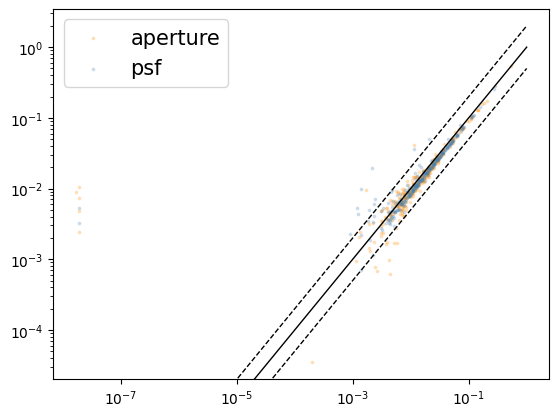

In [835]:

plt.scatter(xa, ya, alpha = 0.2, color ='darkorange', s = 3, label = 'aperture' )
plt.scatter(xs, ys, alpha = 0.2, color = 'steelblue', s = 3, label = 'psf' )

x = np.arange(0, 1, 1e-4)
plt.plot(x, x, color = 'k', lw= 1)
plt.plot(x, 2*x, color = 'k', lw= 1, ls = '--' )
plt.plot(x, 0.5*x, color = 'k', lw= 1, ls = '--' )

plt.xscale('log')
plt.yscale('log')

plt.legend(fontsize = 15)

1.2

6.2188196